In [1]:
import numpy as np
import iris
from iris import cube
import iris.coord_categorisation
import iris.analysis.cartography
import glob
import warnings
from iris.util import equalise_attributes 
from iris.util import unify_time_units
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec as gspec
from matplotlib.lines import Line2D

# Define functions

In [2]:
### Becky CMIP6 functions

#
def combine_netCDF_model(directory, model):

    list_files = glob.glob(directory)
    list_files = np.array(list_files)
    newlist = np.sort(list_files)

    Cubelist = iris.cube.CubeList([])

    for i in range(0, len(newlist)):

        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            warnings.simplefilter('ignore', UserWarning)

            cube = iris.load_cube(newlist[i])
            Cubelist.append(cube)

    unify_time_units(Cubelist)
    equalise_attributes(Cubelist)

    new_cube = Cubelist.concatenate_cube()

    return new_cube

#
def combine_netCDF_cmip6(directory, model):

    list_files = glob.glob(directory)
    list_files = np.array(list_files)
    newlist = np.sort(list_files)

    Cubelist = iris.cube.CubeList([])

    for i in range(0, len(newlist)):

        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            warnings.simplefilter('ignore', UserWarning)
            
            cube = iris.load_cube(newlist[i])

            cube.coord('latitude').attributes = {}
            cube.coord('longitude').attributes = {}  
            if i == 0:
                metadata1 = cube.metadata
            else:
                cube.metadata = metadata1
            
            if model=='IPSL-CM6A-LR' or model=='CNRM-ESM2-1':
                 cube.coord('latitude').guess_bounds()
                 cube.coord('longitude').guess_bounds()
         
            # CESM2 bound issue fix
            if (model=='CESM2') & (i==0):
                lat_data = cube.coord('latitude').points
                lon_data = cube.coord('longitude').points
                lat_bounds = cube.coord('latitude').bounds
                lon_bounds = cube.coord('longitude').bounds
            elif (model=='CESM2') & (i>0):
                cube.coord('latitude').points = lat_data
                cube.coord('longitude').points = lon_data
                cube.coord('latitude').bounds = lat_bounds
                cube.coord('longitude').bounds = lon_bounds
    
            if model=='IPSL-CM6A-LR':
                cube.coord('time').attributes.pop('time_origin')
            
            Cubelist.append(cube)

    unify_time_units(Cubelist)
    equalise_attributes(Cubelist)

    for cube in Cubelist:
        lon_bounds = Cubelist[0].coord('longitude').bounds
        cube.coord('longitude').bounds = lon_bounds

    for i, cube in enumerate(Cubelist):
        if cube.coord('time').units == Cubelist[0].coord('time').units:
            pass
        else:
            print(i)
            
    new_cube = Cubelist.concatenate_cube()

    return new_cube

#
def open_netCDF(new_cube):

    iris.coord_categorisation.add_year(new_cube, 'time', name='year') # add year
    iris.coord_categorisation.add_month(new_cube, 'time', name ='month') # add month
    iris.coord_categorisation.add_month(new_cube, 'time', name ='decade') # add month

    return new_cube

#
def annual_average(new_cube):

    annual_average_cube = new_cube.aggregated_by('year', iris.analysis.MEAN)

    return annual_average_cube

#
def global_total_percentage(cubein, landfrac=None, latlon_cons=None):

    cube = cubein.copy()
    if landfrac is not None:
        try:
            cube.data = cube.data * (landfrac.data/100)
        except:
            landfrac = landfrac.extract(latlon_cons)
            cube.data = cube.data * (landfrac.data/100)

    if cube.coord('latitude').bounds is not None:
        pass
    else:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()

    weights = iris.analysis.cartography.area_weights(cube)

    cube_areaweight = cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=weights)/1e12

    return cube_areaweight

#
def area_average(cube, region):

    lon1, lon2, lat1, lat2 = region[0], region[1], region[2], region[3] 
    cube = cube.intersection(longitude=(lon1, lon2),latitude=(lat1, lat2))

    weights = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['latitude','longitude'], iris.analysis.MEAN, weights=weights)

    return cube


# def centered_moving_average(data, average_length):
#     if average_length < 1:
#         raise ValueError("average_length must be >= 1")
#     if average_length > len(data):
#         raise ValueError("average_length larger than data length")
    
#     kernel = np.ones(average_length) / average_length
#     rolling_avg = np.convolve(data, kernel, mode='valid')

#     return rolling_avg
def centered_moving_average(data, window=20):
    if window % 2 != 0:
        raise ValueError("This function expects an even window size.")
        
    half_window = window // 2

    # Pad the array on both sides
    padded = np.pad(data, (half_window, half_window), mode='edge')
    
    # Compute moving average using convolution
    kernel = np.ones(window) / window
    smoothed = np.convolve(padded, kernel, mode='valid')
    
    return smoothed


def clean_and_convert(x):
    if isinstance(x, (bytes, np.bytes_)):
        x = x.decode()
    x = x.strip("'")  # remove surrounding single quotes
    try:
        return float(x)
    except ValueError:
        return np.nan

# Calculations

### Read CMIP6+ data and calculate beta and gamma land

... from carbon stocks (4xCO2)

In [4]:
import warnings
warnings.filterwarnings("ignore")
### BGC-COU approach with T* = 0, carbon stocks (Arora et al., 2020)

# CO2 array
co2_array = np.zeros((150))
for i in range(0, 150):
        if i == 0:
                co2_array[i] = 285
        else:
            co2_array[i] = co2_array[i-1]*1.01

# C4MIP simulations: '1pctCO2' (COU), '1pctCO2-bgc' (BGC), '1pctCO2-rad' (RAD)

# CMIP6 models
cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL', 'EC-Earth3-CC', 'CMCC-ESM2']
n_models = len(cmip6_models)

cmip6_beta_4xCO2 = np.zeros((len(cmip6_models)))
cmip6_gamma_4xCO2 = np.zeros((len(cmip6_models)))
cmip6_beta_2xCO2 = np.zeros((len(cmip6_models)))
cmip6_gamma_2xCO2 = np.zeros((len(cmip6_models)))

# CMIP6 models loop
for model_i in range(n_models):
        model = cmip6_models[model_i]
        print(model)

        ### read model data
        # land fraction
        if model == 'EC-Earth3-CC':
                model_update = 'EC-Earth3'
                landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_'+model_update+'_historical*', model)
        else:
                landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_'+model+'_historical*', model)


        # BGC Land Carbon (cLand)
        if model == 'UKESM1-0-LL':
                # cVeg
                cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2-bgc*', model)
                cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
                cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
                cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_bgc_data = cVeg_bgc_cube.data
                # cSoil
                cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2-bgc*', model)
                cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
                cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
                cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_bgc_data = cSoil_bgc_cube.data
                # 
                cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

                time_dimension = cVeg_bgc_cube.coord('year').points
        #elif model == 'BCC-CSM2-MR' or model == 'MIROC-ES2L':
        elif model == 'BCC-CSM2-MR' or model == 'MIROC-ES2L' or model == 'ACCESS-ESM1-5' or model == 'CanESM5' or model == 'CESM2' or model == 'GFDL-ESM4' or model == 'IPSL-CM6A-LR' or model == 'MPI-ESM1-2-LR' or model == 'NorESM2-LM':
                # cVeg
                cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2-bgc*', model)
                cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
                cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
                cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_bgc_data = cVeg_bgc_cube.data
                # cSoil
                cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2-bgc*', model)
                cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
                cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
                cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_bgc_data = cSoil_bgc_cube.data 
                # cLitter
                cLitter_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLitter_Lmon_'+model+'_1pctCO2-bgc*', model)
                cLitter_bgc_cube = open_netCDF(cLitter_bgc_cube)
                cLitter_bgc_cube = annual_average(cLitter_bgc_cube)
                cLitter_bgc_cube = global_total_percentage(cLitter_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cLitter_bgc_data = cLitter_bgc_cube.data
                # 
                cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data + cLitter_bgc_data

                # Time dimension
                if model == 'ACCESS-ESM1-5':
                        time_dimension = cVeg_bgc_cube.coord('year').points
                        time_dimension = time_dimension - 100
                else:
                        time_dimension = cVeg_bgc_cube.coord('year').points
                
        else:
                # cLand
                cLand_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLand_Emon_'+model+'_1pctCO2-bgc*', model)
                cLand_bgc_cube = open_netCDF(cLand_bgc_cube)
                cLand_bgc_cube = annual_average(cLand_bgc_cube)
                cLand_bgc_cube = global_total_percentage(cLand_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cLand_bgc_data = cLand_bgc_cube.data

                time_dimension = cLand_bgc_cube.coord('year').points

        # COU Land Carbon (cLand)
        if model == 'BCC-CSM2-MR' or model == 'NorESM2-LM':
                # cVeg
                cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2_*', model)
                cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
                cVeg_cou_cube = annual_average(cVeg_cou_cube)
                cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_cou_data = cVeg_cou_cube.data
                # cSoil
                cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2_*', model)
                cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
                cSoil_cou_cube = annual_average(cSoil_cou_cube)
                cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_cou_data = cSoil_cou_cube.data 
                # cLitter
                cLitter_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLitter_Lmon_'+model+'_1pctCO2_*', model)
                cLitter_cou_cube = open_netCDF(cLitter_cou_cube)
                cLitter_cou_cube = annual_average(cLitter_cou_cube)
                cLitter_cou_cube = global_total_percentage(cLitter_cou_cube, landfrac=landfraction, latlon_cons=None)
                cLitter_cou_data = cLitter_cou_cube.data
                # 
                cLand_cou_data = cVeg_cou_data + cSoil_cou_data + cLitter_cou_data
        else:
                # cLand
                cLand_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLand_Emon_'+model+'_1pctCO2_*', model)
                cLand_cou_cube = open_netCDF(cLand_cou_cube)
                cLand_cou_cube = annual_average(cLand_cou_cube)
                cLand_cou_cube = global_total_percentage(cLand_cou_cube, landfrac=landfraction, latlon_cons=None)
                cLand_cou_data = cLand_cou_cube.data

        # Temperature (tas)
        tas_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/tas_Amon_'+model+'_1pctCO2_*', model)
        tas_cou_cube = open_netCDF(tas_cou_cube)
        tas_cou_cube = annual_average(tas_cou_cube)
        tas_cou_cube = area_average(tas_cou_cube - 273.15, [0, 360, -90,  90])
        tas_cou_data = tas_cou_cube.data
        tas_cou_data = centered_moving_average(tas_cou_data, 20)

        ### calculate beta and gamma land (4xCO2)
        # beta
        dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
        dCo2 = co2_array[139] - co2_array[0]
        beta = dC_bgc/dCo2

        # gamma
        dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
        dT_cou = tas_cou_data[139] - tas_cou_data[0]
        dC_res = dC_cou - dC_bgc
        gamma = dC_res/dT_cou

        print('4xCO2 T*=0', model, beta, gamma)

        # saving
        cmip6_beta_4xCO2[model_i] = beta
        cmip6_gamma_4xCO2[model_i] = gamma

        ### calculate beta and gamma land (2xCO2)
        # beta
        dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
        dCo2 = co2_array[70] - co2_array[0]
        beta = dC_bgc/dCo2

        # gamma
        dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
        dT_cou = tas_cou_data[70] - tas_cou_data[0]
        dC_res = dC_cou - dC_bgc
        gamma = dC_res/dT_cou

        print('2xCO2 T*=0', model, beta, gamma)

        # saving
        cmip6_beta_2xCO2[model_i] = beta
        cmip6_gamma_2xCO2[model_i] = gamma

np.save('saved_data/cmip6_beta_4xCO2.npy', cmip6_beta_4xCO2.data)
np.save('saved_data/cmip6_gamma_4xCO2.npy', cmip6_gamma_4xCO2.data)
np.save('saved_data/cmip6_beta_2xCO2.npy', cmip6_beta_2xCO2.data)
np.save('saved_data/cmip6_gamma_2xCO2.npy', cmip6_gamma_2xCO2.data)


ACCESS-ESM1-5
4xCO2 T*=0 ACCESS-ESM1-5 0.3175725700316628 -16.854052212916567
2xCO2 T*=0 ACCESS-ESM1-5 0.6430021087497766 -4.878487861165498
BCC-CSM2-MR
4xCO2 T*=0 BCC-CSM2-MR 1.4241866284704114 -149.69870036481382
2xCO2 T*=0 BCC-CSM2-MR 1.7183581950158302 -88.57084264329005
CanESM5
4xCO2 T*=0 CanESM5 1.2950877718751075 17.067449554652388
2xCO2 T*=0 CanESM5 1.4171133107642686 -5.086538572885058
CESM2
4xCO2 T*=0 CESM2 0.8025117754937375 -6.2053916301738195
2xCO2 T*=0 CESM2 0.8783746599503601 -0.4758705537621961
CNRM-ESM2-1
4xCO2 T*=0 CNRM-ESM2-1 1.355566921250886 -85.34090402148307
2xCO2 T*=0 CNRM-ESM2-1 1.3665514793655869 -51.900089031020244
GFDL-ESM4
4xCO2 T*=0 GFDL-ESM4 0.905366933292723 -70.4296863962573
2xCO2 T*=0 GFDL-ESM4 1.0642147201212333 -46.43017123619541
IPSL-CM6A-LR
4xCO2 T*=0 IPSL-CM6A-LR 0.6155894495224171 -13.8373799048245
2xCO2 T*=0 IPSL-CM6A-LR 1.0853299008300628 -26.301715011927737
MIROC-ES2L
4xCO2 T*=0 MIROC-ES2L 1.0958262865901398 -66.79750270669676
2xCO2 T*=0 MIROC

### Additional process ensembles and calculate beta and gamma land

##### IPSL_Perm_LandN

In [12]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc', model)

# BGC Land Carbon (cLand)
cLand_bgc_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/outputs_IPSL_Perm_LandN/1pctCO2-bgc/cLand_1pctCO2-bgc_IPSL_Perm_LandN_18500101_19891231.nc', 'cLand')
for i,coord in enumerate(cLand_bgc_cube.coords('time')): 
    if i==1: cLand_bgc_cube.remove_coord(coord)           # remove auxiliary time coordinate (since data has 2 time coords)
cLand_bgc_cube = open_netCDF(cLand_bgc_cube)
cLand_bgc_cube = annual_average(cLand_bgc_cube)
cLand_bgc_cube = global_total_percentage(cLand_bgc_cube, landfrac=landfraction, latlon_cons=None)
cLand_bgc_data = cLand_bgc_cube.data
time_dimension = cLand_bgc_cube.coord('year').points

# # COU Land Carbon (cLand) 
cLand_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/outputs_IPSL_Perm_LandN/1pctCO2/cLand_1pctCO2_IPSL_Perm_LandN_18500101_19891231.nc', 'cLand')
for i,coord in enumerate(cLand_cou_cube.coords('time')): 
    if i==1: cLand_cou_cube.remove_coord(coord)           # remove auxiliary time coordinate (since data has 2 time coords)
cLand_cou_cube = open_netCDF(cLand_cou_cube)
cLand_cou_cube = annual_average(cLand_cou_cube)
cLand_cou_cube = global_total_percentage(cLand_cou_cube, landfrac=landfraction, latlon_cons=None)
cLand_cou_data = cLand_cou_cube.data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/outputs_IPSL_Perm_LandN/1pctCO2/tas_1pctCO2_IPSL_Perm_LandN_18500101_19891231_fldm_ym.nc', 'tas')
tas_cou_data = tas_cou_cube.data - 273.15
tas_cou_data = centered_moving_average(tas_cou_data.data.flatten(), 20)


### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'IPSL_Perm_LandN', beta, gamma)

IPSL_Perm_LandN_beta_4xCO2 = beta
IPSL_Perm_LandN_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'IPSL_Perm_LandN', beta, gamma)

IPSL_Perm_LandN_beta_2xCO2 = beta
IPSL_Perm_LandN_gamma_2xCO2 = gamma


np.save('saved_data/IPSL_Perm_LandN_beta_2xCO2.npy', IPSL_Perm_LandN_beta_2xCO2.data)
np.save('saved_data/IPSL_Perm_LandN_gamma_2xCO2.npy', IPSL_Perm_LandN_gamma_2xCO2.data)
np.save('saved_data/IPSL_Perm_LandN_beta_4xCO2.npy', IPSL_Perm_LandN_beta_4xCO2.data)
np.save('saved_data/IPSL_Perm_LandN_gamma_4xCO2.npy', IPSL_Perm_LandN_gamma_4xCO2.data)

4xCO2 T*=0 IPSL_Perm_LandN 0.06825994402831599 -2.5611342031422755
2xCO2 T*=0 IPSL_Perm_LandN 0.11281556306893711 -0.2594296493905209


##### CNRM-ESM2-1 (wo/w crop_harvest)

In [32]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_CNRM-ESM2-1_historical_*.nc', 'CNRM-ESM2-1')

# BGC Land Carbon (cLand)
cLand_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/cLand_Eyr_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gr_185001-198912.nc', 'CNRM-ESM2-1')
cLand_bgc_cube = open_netCDF(cLand_bgc_cube)
cLand_bgc_cube = annual_average(cLand_bgc_cube)
cLand_bgc_cube = global_total_percentage(cLand_bgc_cube, landfrac=landfraction, latlon_cons=None)
cLand_bgc_data = cLand_bgc_cube.data

# COU Land Carbon (cLand)
cLand_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/cLand_Eyr_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc', 'CNRM-ESM2-1')                                                                 
cLand_cou_cube = open_netCDF(cLand_cou_cube)
cLand_cou_cube = annual_average(cLand_cou_cube)
cLand_cou_cube = global_total_percentage(cLand_cou_cube, landfrac=landfraction, latlon_cons=None)
cLand_cou_data = cLand_cou_cube.data[:140]  # adjust to 140 years for 1pctCO2

# Temperature (tas)
tas_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/tas_Ayr_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc', 'CNRM-ESM2-1')
tas_cou_cube = open_netCDF(tas_cou_cube)
tas_cou_cube = annual_average(tas_cou_cube)
tas_cou_cube = area_average(tas_cou_cube - 273.15, [0, 360, -90,  90])
tas_cou_data = tas_cou_cube.data
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'CNRM-ESM2-1 without crop harvest', beta, gamma)
CNRM1_cLand_bgc = cLand_bgc_data
CNRM1_cLand_cou = cLand_cou_data
CNRM1_tas_cou = tas_cou_data
print(dC_bgc, dCo2, beta)
print(dC_cou, dT_cou, dC_res, gamma)

CNRM_noharvest_beta_4xCO2 = beta
CNRM_noharvest_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'CNRM-ESM2-1 without crop harvest', beta, gamma)

CNRM_noharvest_beta_2xCO2 = beta
CNRM_noharvest_gamma_2xCO2 = gamma


np.save('saved_data/CNRM_noharvest_beta_4xCO2.npy', CNRM_noharvest_beta_4xCO2.data)
np.save('saved_data/CNRM_noharvest_gamma_4xCO2.npy', CNRM_noharvest_gamma_4xCO2.data)
np.save('saved_data/CNRM_noharvest_beta_2xCO2.npy', CNRM_noharvest_beta_2xCO2.data)
np.save('saved_data/CNRM_noharvest_gamma_2xCO2.npy', CNRM_noharvest_gamma_2xCO2.data)

4xCO2 T*=0 CNRM-ESM2-1 without crop harvest 1.355566914236889 -85.34090072053084
1154.075014281797 851.3596799693794 1.355566914236889
714.6758359207852 5.1487525284028735 -439.39917836101176 -85.34090072053084
2xCO2 T*=0 CNRM-ESM2-1 without crop harvest 1.366551484460287 -51.90008883859762


In [33]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_CNRM-ESM2-1_historical_*.nc', 'CNRM-ESM2-1')

# BGC Land Carbon (cLand)
cLand_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/cLand_Eyr_CNRM-ESM2-1_1pctCO2-bgc_r1i1p2f2_gr_185001-199912.nc', 'CNRM-ESM2-1')
cLand_bgc_cube = open_netCDF(cLand_bgc_cube)
cLand_bgc_cube = annual_average(cLand_bgc_cube)
cLand_bgc_cube = global_total_percentage(cLand_bgc_cube, landfrac=landfraction, latlon_cons=None)
cLand_bgc_data = cLand_bgc_cube.data[:140]

# COU Land Carbon (cLand)
cLand_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/cLand_Eyr_CNRM-ESM2-1_1pctCO2_r1i1p2f2_gr_185001-199912.nc', 'CNRM-ESM2-1')                                                                 
cLand_cou_cube = open_netCDF(cLand_cou_cube)
cLand_cou_cube = annual_average(cLand_cou_cube)
cLand_cou_cube = global_total_percentage(cLand_cou_cube, landfrac=landfraction, latlon_cons=None)
cLand_cou_data = cLand_cou_cube.data[:140]  # adjust to 140 years for 1pctCO2

# Temperature (tas)
tas_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CNRM-ESM2-1_crop_harvest/tas_Ayr_CNRM-ESM2-1_1pctCO2_r1i1p2f2_gr_185001-199912.nc', 'CNRM-ESM2-1')
tas_cou_cube = open_netCDF(tas_cou_cube)
tas_cou_cube = annual_average(tas_cou_cube)
tas_cou_cube = area_average(tas_cou_cube - 273.15, [0, 360, -90,  90])
tas_cou_data = tas_cou_cube.data[:140]
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'CNRM-ESM2-2 with crop harvest', beta, gamma)
CNRM2_cLand_bgc = cLand_bgc_data
CNRM2_cLand_cou = cLand_cou_data
CNRM2_tas_cou = tas_cou_data
print(dC_bgc, dCo2, beta)
print(dC_cou, dT_cou, dC_res, gamma)

CNRM_harvest_beta_4xCO2 = beta
CNRM_harvest_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'CNRM-ESM2-2 with crop harvest', beta, gamma)

CNRM_harvest_beta_2xCO2 = beta
CNRM_harvest_gamma_2xCO2 = gamma

np.save('saved_data/CNRM_harvest_beta_4xCO2.npy', CNRM_harvest_beta_4xCO2.data)
np.save('saved_data/CNRM_harvest_gamma_4xCO2.npy', CNRM_harvest_gamma_4xCO2.data)
np.save('saved_data/CNRM_harvest_beta_2xCO2.npy', CNRM_harvest_beta_2xCO2.data)
np.save('saved_data/CNRM_harvest_gamma_2xCO2.npy', CNRM_harvest_gamma_2xCO2.data)

4xCO2 T*=0 CNRM-ESM2-2 with crop harvest 1.3195731899503202 -76.32814969085611
1123.4314086922777 851.3596799693794 1.3195731899503202
714.3010730432184 5.360150053500799 -409.13033564905936 -76.32814969085611
2xCO2 T*=0 CNRM-ESM2-2 with crop harvest 1.3203040212459034 -45.258475378252264


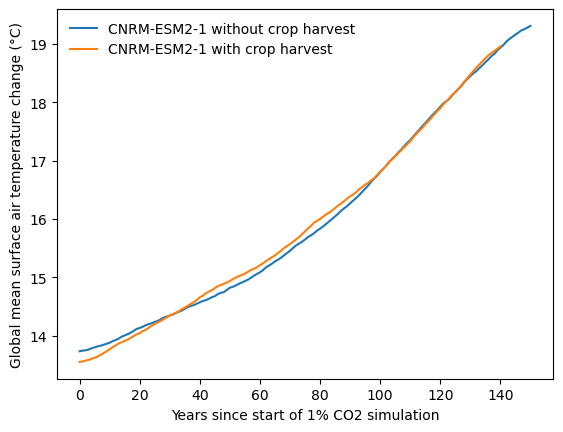

In [37]:
plt.plot(CNRM1_tas_cou, label='CNRM-ESM2-1 without crop harvest')
plt.plot(CNRM2_tas_cou, label='CNRM-ESM2-1 with crop harvest')
plt.xlabel('Years since start of 1% CO2 simulation')
plt.ylabel('Global mean surface air temperature change (°C)')
plt.legend(frameon=False)

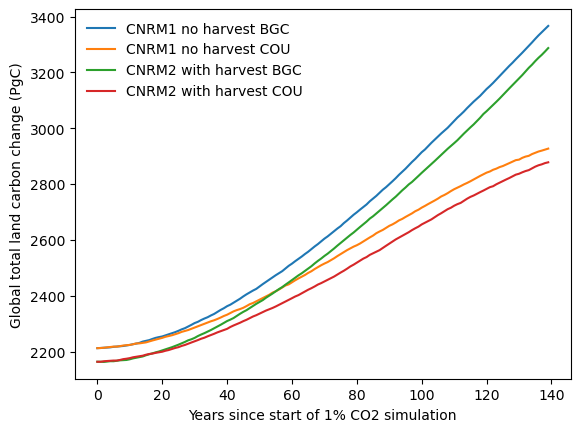

In [38]:
plt.plot(CNRM1_cLand_bgc, label='CNRM1 no harvest BGC')
plt.plot(CNRM1_cLand_cou, label='CNRM1 no harvest COU')
plt.plot(CNRM2_cLand_bgc, label='CNRM2 with harvest BGC')
plt.plot(CNRM2_cLand_cou, label='CNRM2 with harvest COU')
plt.xlabel('Years since start of 1% CO2 simulation')
plt.ylabel('Global total land carbon change (PgC)')
plt.legend(frameon=False)

##### ACCESS-ESM_CNP

1. "C" variant

In [15]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_ACCESS-ESM1-5_historical_*.nc', 'ACCESS-ESM1-5')

# Land Carbon (BGC and COU): The order in the netcdf files is [COU, BGC, RAD]
cLand_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/cland_c.nc', 'cpool_c_sum')
cLand_cube = open_netCDF(cLand_cube)
cLand_cube = annual_average(cLand_cube)

cLand_cou_data = cLand_cube.data[:140,0]
cLand_bgc_data = cLand_cube.data[:140,1]

time_dimension = cLand_cube.coord('year').points - 100

# Temperature (tas)
tas_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/tas_c.nc', 'tas_c_sum')
tas_cube = open_netCDF(tas_cube)
tas_cou_data = tas_cube.data[:140,0] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)


### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'ACCESS-ESM C', beta, gamma)

ACCESS_C_beta_4xCO2 = beta
ACCESS_C_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'ACCESS-ESM C', beta, gamma)

ACCESS_C_beta_2xCO2 = beta
ACCESS_C_gamma_2xCO2 = gamma

np.save('saved_data/ACCESS-ESM_C_beta_4xCO2.npy', ACCESS_C_beta_4xCO2.data)
np.save('saved_data/ACCESS-ESM_C_gamma_4xCO2.npy', ACCESS_C_gamma_4xCO2.data)
np.save('saved_data/ACCESS-ESM_C_beta_2xCO2.npy', ACCESS_C_beta_2xCO2.data)
np.save('saved_data/ACCESS-ESM_C_gamma_2xCO2.npy', ACCESS_C_gamma_2xCO2.data)

4xCO2 T*=0 ACCESS-ESM C 1.0301858265825503 -111.83605968091611
2xCO2 T*=0 ACCESS-ESM C 1.565401921716402 -77.02020006761697


2. "CN" variant

In [17]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_ACCESS-ESM1-5_historical_*.nc', 'ACCESS-ESM1-5')

# Land Carbon (BGC and COU): The order in the netcdf files is [COU, BGC, RAD]
cLand_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/cland_cn.nc', 'cpool_cn_sum')
cLand_cube = open_netCDF(cLand_cube)
cLand_cube = annual_average(cLand_cube)

cLand_cou_data = cLand_cube.data[:140,0]
cLand_bgc_data = cLand_cube.data[:140,1]

time_dimension = cLand_cube.coord('year').points - 100

# Temperature (tas)
tas_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/tas_cn.nc', 'tas_cn_sum')
tas_cube = open_netCDF(tas_cube)
tas_cou_data = tas_cube.data[:140,0] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)


### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'ACCESS-ESM CN', beta, gamma)

ACCESS_CN_beta_4xCO2 = beta
ACCESS_CN_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'ACCESS-ESM CN', beta, gamma)

ACCESS_CN_beta_2xCO2 = beta
ACCESS_CN_gamma_2xCO2 = gamma

np.save('saved_data/ACCESS-ESM_CN_beta_4xCO2.npy', ACCESS_CN_beta_4xCO2.data)
np.save('saved_data/ACCESS-ESM_CN_gamma_4xCO2.npy', ACCESS_CN_gamma_4xCO2.data)
np.save('saved_data/ACCESS-ESM_CN_beta_2xCO2.npy', ACCESS_CN_beta_2xCO2.data)
np.save('saved_data/ACCESS-ESM_CN_gamma_2xCO2.npy', ACCESS_CN_gamma_2xCO2.data)

4xCO2 T*=0 ACCESS-ESM CN 0.7613031423555225 -85.6435564586165
2xCO2 T*=0 ACCESS-ESM CN 1.2962059512510677 -69.77584044909005


3. "CNP" variant

In [16]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_ACCESS-ESM1-5_historical_*.nc', 'ACCESS-ESM1-5')

# Land Carbon (BGC and COU): The order in the netcdf files is [COU, BGC, RAD]
cLand_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/cland_cnp.nc', 'cpool_cnp_sum')
cLand_cube = open_netCDF(cLand_cube)
cLand_cube = annual_average(cLand_cube)

cLand_cou_data = cLand_cube.data[:140,0]
cLand_bgc_data = cLand_cube.data[:140,1]

time_dimension = cLand_cube.coord('year').points - 100

# Temperature (tas)
tas_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/ACCESS-ESM_CNP/tas_cnp.nc', 'tas_cnp_sum')
tas_cube = open_netCDF(tas_cube)
tas_cou_data = tas_cube.data[:140,0] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)


### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'ACCESS-ESM CNP', beta, gamma)

ACCESS_CNP_beta_4xCO2 = beta
ACCESS_CNP_gamma_4xCO2 = gamma

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'ACCESS-ESM CN', beta, gamma)

ACCESS_CNP_beta_2xCO2 = beta
ACCESS_CNP_gamma_2xCO2 = gamma


np.save('saved_data/ACCESS-ESM_CNP_beta_4xCO2.npy', ACCESS_CNP_beta_4xCO2.data)
np.save('saved_data/ACCESS-ESM_CNP_gamma_4xCO2.npy', ACCESS_CNP_gamma_4xCO2.data)
np.save('saved_data/ACCESS-ESM_CNP_beta_2xCO2.npy', ACCESS_CNP_beta_2xCO2.data)
np.save('saved_data/ACCESS-ESM_CNP_gamma_2xCO2.npy', ACCESS_CNP_gamma_2xCO2.data)

4xCO2 T*=0 ACCESS-ESM CNP 0.3484593463270184 -20.859202635114045
2xCO2 T*=0 ACCESS-ESM CN 0.708915880116943 -10.499496519826934


##### UKESM (Liddicoat ensemble)

1. Control

In [93]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp596_ukesm-ctrl_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp596_ukesm-ctrl_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp593_ukesm-ctrl_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp593_ukesm-ctrl_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp593_ukesm-ctrl_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL ctrl', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL ctrl', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL ctrl 0.7519019370137425 -41.32766664030126
2xCO2 T*=0 UKESM1-0-LL ctrl 1.0365219572712858 -28.815910024264323


2. nodgvm

In [94]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp228_ukesm-nodgvm_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp228_ukesm-nodgvm_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp227_ukesm-nodgvm_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp227_ukesm-nodgvm_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp227_ukesm-nodgvm_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL nodgvm', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL nodgvm', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL nodgvm 0.5849899171647202 -44.604309901213874
2xCO2 T*=0 UKESM1-0-LL nodgvm 0.8491160098396161 -30.059545720591316


3. nonlim

In [96]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp217_ukesm-nonlim_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp217_ukesm-nonlim_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp184_ukesm-nonlim_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp184_ukesm-nonlim_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-cp184_ukesm-nonlim_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL nonlim', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL nonlim', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL nonlim 1.239681623488967 -67.45926598410999
2xCO2 T*=0 UKESM1-0-LL nonlim 1.3925455758470322 -29.0478165715125


4. df

In [98]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da685_ukesm-df_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da685_ukesm-df_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da684_ukesm-df_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da684_ukesm-df_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da684_ukesm-df_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL df', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL df', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL df 0.7385940049787487 -43.71730481563087
2xCO2 T*=0 UKESM1-0-LL df 0.9963451240766126 -28.94228806791291


5. bvoc

In [100]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da690_ukesm-bvoc_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da690_ukesm-bvoc_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da688_ukesm-bvoc_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da688_ukesm-bvoc_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-da688_ukesm-bvoc_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL bvoc', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL bvoc', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL bvoc 0.7573898738500063 -38.91065178818534
2xCO2 T*=0 UKESM1-0-LL bvoc 1.047968235222553 -26.47100172603313


6. fire

In [103]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-ct808_ukesm-fire_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-ct808_ukesm-fire_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-ct798_ukesm-fire_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-ct798_ukesm-fire_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-ct798_ukesm-fire_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL fire', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL fire', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL fire 0.5727919882572527 -67.55053258619975
2xCO2 T*=0 UKESM1-0-LL fire 0.7885995626983306 -41.820301438219


7. wch4

In [105]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dc220_ukesm-wch4_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dc220_ukesm-wch4_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dc218_ukesm-wch4_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dc218_ukesm-wch4_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dc218_ukesm-wch4_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL wch4', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL wch4', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL wch4 0.7462170048799446 -40.87385894260833
2xCO2 T*=0 UKESM1-0-LL wch4 1.0359423954802194 -27.065096068628474


8. allprocs

In [107]:
### Read data
# landfraction
landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_UKESM1-0-LL_historical_*.nc', 'UKESM1-0-LL')

# BGC Land Carbon (cLand)
cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dd475_ukesm-allprocs_1pctCO2bgc_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
cVeg_bgc_data = cVeg_bgc_cube.data

cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dd475_ukesm-allprocs_1pctCO2bgc_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
cSoil_bgc_data = cSoil_bgc_cube.data

cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

# COU Land Carbon (cLand)
cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dd474_ukesm-allprocs_1pctCO2cou_vegetation_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
cVeg_cou_cube = annual_average(cVeg_cou_cube)
cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
cVeg_cou_data = cVeg_cou_cube.data

cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dd474_ukesm-allprocs_1pctCO2cou_soil_carbon_kgC_m2.nc', 'UKESM1-0-LL')
cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
cSoil_cou_cube = annual_average(cSoil_cou_cube)
cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
cSoil_cou_data = cSoil_cou_cube.data

cLand_cou_data = cVeg_cou_data + cSoil_cou_data

# Temperature (tas)
tas_cou_cube = iris.load_cube('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/UKESM-ensemble/u-dd474_ukesm-allprocs_1pctCO2cou_1p5m_temperature_K_ym_fldm.nc', 'air_temperature')
tas_cou_data = tas_cou_cube.data.squeeze()[0:140] - 273.15
tas_cou_data = centered_moving_average(tas_cou_data, 20)

### calculate beta and gamma land (4xCO2)
# beta
dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
dCo2 = co2_array[139] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
dT_cou = tas_cou_data[139] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('4xCO2 T*=0', 'UKESM1-0-LL allprocs', beta, gamma)

### calculate beta and gamma land (2xCO2)
# beta
dC_bgc = cLand_bgc_data[70] - cLand_bgc_data[0]
dCo2 = co2_array[70] - co2_array[0]
beta = dC_bgc/dCo2

# gamma
dC_cou = cLand_cou_data[70] - cLand_cou_data[0]
dT_cou = tas_cou_data[70] - tas_cou_data[0]
dC_res = dC_cou - dC_bgc
gamma = dC_res/dT_cou

print('2xCO2 T*=0', 'UKESM1-0-LL allprocs', beta, gamma)


4xCO2 T*=0 UKESM1-0-LL allprocs 0.5469299992142465 -63.978707908986436
2xCO2 T*=0 UKESM1-0-LL allprocs 0.7231418474796881 -35.06289791529763
